# Transformer Input Pipeline
## Import data

In [25]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import DistilBertTokenizerFast


In [6]:
df = pd.read_csv('train.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df.drop(['PhraseId','SentenceId'], axis =1, inplace= True)
df.tail()

,Phrase,Sentiment
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2
156059,chortles,2


In [8]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 2 if x > 2 else (1 if x == 2 else 0 ))
df.tail()

,Phrase,Sentiment
156055,Hearst 's,1
156056,forced avuncular chortles,0
156057,avuncular chortles,2
156058,avuncular,1
156059,chortles,1


In [10]:
seqlen = df['Phrase'].apply(lambda x:len(x.split()))
seqlen

0         37
1         14
2          2
3          1
4          1
          ..
156055     2
156056     3
156057     2
156058     1
156059     1
Name: Phrase, Length: 156060, dtype: int64

<Figure size 2304x1440 with 0 Axes>

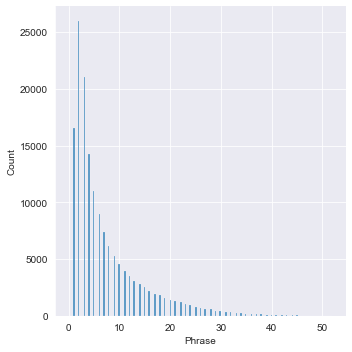

In [12]:
sns.set_style('darkgrid')
plt.figure(figsize=(32,20))
sns.displot(seqlen)

In [17]:
from transformers import BertTokenizer

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading: 100%|██████████| 208k/208k [00:00<00:00, 818kB/s] 
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 12.7kB/s]
Downloading: 100%|██████████| 426k/426k [00:00<00:00, 1.01MB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 233kB/s]


In [22]:
SEQLEN = 512

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']



In [19]:
Xraw = df['Phrase'].values
Xraw[:5]

array(['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
       'A series of escapades demonstrating the adage that what is good for the goose',
       'A series', 'A', 'series'], dtype=object)

In [40]:
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)  # required to avoid GPU LSTM Internal Error
tf.config.experimental.list_physical_devices('GPU')

[]

In [41]:
input_ids=[]
attention_mask=[]

for item in Xraw:
    input_id, mask = tokenize(item)
    input_ids.append(input_id)
    attention_mask.append(mask)

In [42]:
Xids = np.asarray(input_ids)
Xmask = np.asarray(attention_mask)
print(Xids.shape)
print(Xmask.shape)


(156060, 1, 512)
(156060, 1, 512)


In [43]:
Xmask

array([[[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0]]], dtype=int32)

In [44]:
Xids

array([[[  101,   138,  1326, ...,     0,     0,     0]],

       [[  101,   138,  1326, ...,     0,     0,     0]],

       [[  101,   138,  1326, ...,     0,     0,     0]],

       ...,

       [[  101,   170, 25247, ...,     0,     0,     0]],

       [[  101,   170, 25247, ...,     0,     0,     0]],

       [[  101, 22572, 12148, ...,     0,     0,     0]]], dtype=int32)

In [45]:
arr = df['Sentiment'].values

In [46]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(156060, 3)

In [47]:
np.arange(arr.size)

array([     0,      1,      2, ..., 156057, 156058, 156059])

In [48]:
labels[np.arange(arr.size),arr] = 1
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [49]:
with open('xids.npy','wb')as f:
    np.save(f,Xids)

In [50]:
with open('xmask.npy','wb')as f:
    np.save(f,Xmask)

In [51]:
with open('labels.npy','wb')as f:
    np.save(f,labels)